In [1]:
!git clone https://github.com/Jsrsky/machine_unlearning_experiments
%cd machine_unlearning_experiments/experiments/animal_faces/naive

Cloning into 'machine_unlearning_experiments'...
remote: Enumerating objects: 452, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 452 (delta 11), reused 26 (delta 7), pack-reused 374 (from 3)
Receiving objects: 100% (452/452), 628.82 MiB | 41.28 MiB/s, done.
Resolving deltas: 100% (146/146), done.
Updating files: 100% (66/66), done.
/kaggle/working/machine_unlearning_experiments/experiments/animal_faces/naive


## Dependecies

In [7]:
import sys
from pathlib import Path
from torchvision import datasets

## Utils

In [3]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


# DELETE IF GOING FOR LOCAL SETUP, ADD AHFQ DATASET TO "./data" FOLDER

In [4]:
data_root = Path('/kaggle/input/animal-faces')

In [5]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

# Prepare Dataloaders
from methods.naive.naive_utils import init_dataloaders

# Train loop
from utils.train_test_metrics import train_model

# Plot losses
from utils.train_test_metrics import plot_training_history

# Test function
from utils.train_test_metrics import test_model

# Merics 
from utils.train_test_metrics import show_metrics

# Init model
from models.effnetb0 import init_model_effnetb0

Device used: cuda


## Parameters (arbitrary chosen)

In [6]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 3

# Simple base training

## Init model

In [15]:
model, model_name, criterion, optimizer, transform = init_model_effnetb0(learning_rate=LEARNING_RATE, fc_output=3)

Init model...
Done initializing model.
Model ID: 137407102378256, Optimizer ID: 137407102378064, Criterion ID: 137407102377728


## Init dataloaders

In [16]:
train_dataset = datasets.ImageFolder(root=data_root/'afhq/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_root/'afhq/val', transform=transform)
data_split_path = 'afhq_data_splits.json'

train_loader, val_loader, test_loader, classes = init_dataloaders(
    datasets=(train_dataset, test_dataset),
    val_ratio=0.2,
    batch_size=BATCH_SIZE,
    info_file_path = data_split_path,
    )

Prepare DataLoaders...
Done preparing DataLoaders.


## Call train

In [17]:
import time
start_time = time.perf_counter()
train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS)
end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Evaluating on validation set...: 100%|██████████| 46/46 [00:26<00:00,  1.72it/s]


Epoch [1/3], Train Loss: 0.0560, Train Accuracy: 0.9839, Val Loss: 0.0149, Val Accuracy: 0.9952
Epoch 1: New best validation accuracy: 0.9952. Model saved to EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 46/46 [00:24<00:00,  1.91it/s]


Epoch [2/3], Train Loss: 0.0150, Train Accuracy: 0.9947, Val Loss: 0.0490, Val Accuracy: 0.9843


Evaluating on validation set...: 100%|██████████| 46/46 [00:24<00:00,  1.84it/s]

Epoch [3/3], Train Loss: 0.0167, Train Accuracy: 0.9946, Val Loss: 0.0246, Val Accuracy: 0.9932
Training complete for EffNetB0_AFHQ. Training stats saved to 'EffNetB0_AFHQ_history.json'.
Execution time: 509.950064 seconds


## Plot history losses

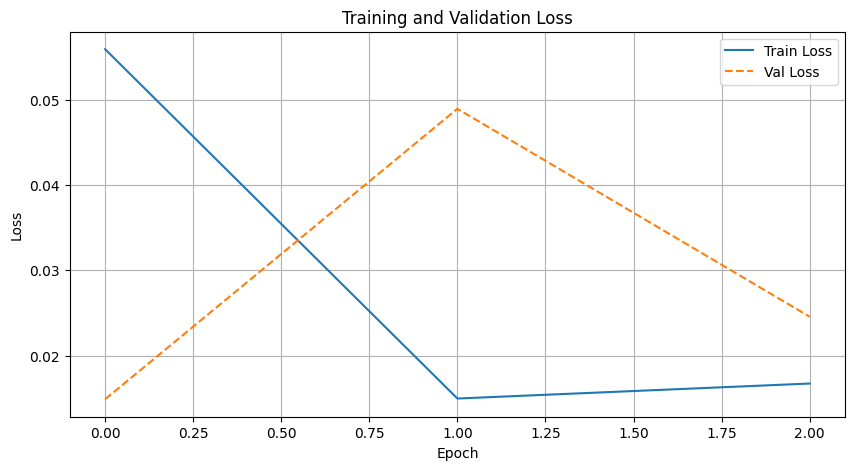

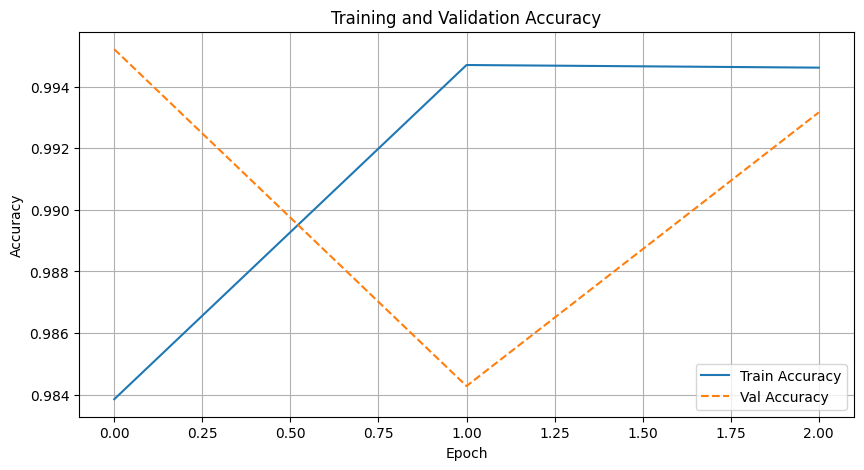

In [18]:
history_path = f'{model_name}_history.json'
plot_training_history(history_path)

## Call test

In [19]:
model_path = f"{model_name}_model.pth"
test_model(model, model_name, model_path, test_loader)

Loading and testing model: EffNetB0_AFHQ


Evaluating model: EffNetB0_AFHQ_model.pth: 100%|██████████| 24/24 [00:13<00:00,  1.81it/s]

Predictions and labels saved to EffNetB0_AFHQ_predictions.json


## Show metrics

Metrics for EffNetB0_AFHQ:
  - Test Accuracy: 0.9980
  - Precision: 0.9980
  - Recall: 0.9980
  - F1 Score: 0.9980


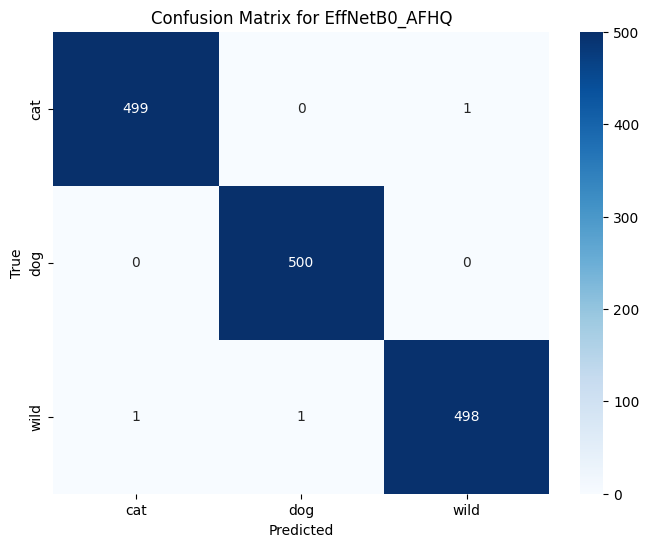

In [20]:
predictions_path = f'{model_name}_predictions.json'
#classes = ['cat', 'dog', 'wildlife']
show_metrics(predictions_path, classes, model_name)

## Utils naive

In [8]:
# Select samples to unlearn (10% random)
from utils.utils import select_samples_to_unlearn

# Update data splits
from methods.naive.naive_utils import update_splits_after_unlearning

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# Naive unlearning

### Init new model

In [9]:
data_splits_file = "afhq_data_splits.json"
unlearn_samples_file = "afhq_samples_to_unlearn_30per.json"
updated_data_splits_path = "updated_afhq_data_splits.json"

In [10]:
model, model_name, criterion, optimizer, transform = init_model_effnetb0(learning_rate=LEARNING_RATE, fc_output=3)
model_name = "naive_unlearning_" + model_name

Init model...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 129MB/s] 


Done initializing model.
Model ID: 139152978504016, Optimizer ID: 139152978508288, Criterion ID: 139152978504640


### Init data

In [11]:
train_dataset = datasets.ImageFolder(root=data_root/'afhq/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_root/'afhq/val', transform=transform)

## Select samples to unlearn

In [12]:
#ONLY ONCE
select_samples_to_unlearn(data_splits_file, unlearn_samples_file, unlearn_ratio=0.3)

Unlearn indices saved to afhq_samples_to_unlearn_30per.json


## Update data splits -> delete samples

In [13]:
update_splits_after_unlearning(data_splits_file, unlearn_samples_file, updated_data_splits_path)

Updated splits saved to updated_afhq_data_splits.json


## Recreate DataLoaders from json files

In [14]:
train_loader, val_loader, test_loader, classes = recreate_dataloaders(
    data_splits_file=updated_data_splits_path,
    datasets=(train_dataset, test_dataset), 
    batch_size=BATCH_SIZE)

Recreating DataLoaders...
Done recreating DataLoaders.


## Re-train

In [15]:
import time
start_time = time.perf_counter()
train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS)
end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Evaluating on validation set...: 100%|██████████| 33/33 [00:23<00:00,  1.39it/s]


Epoch [1/3], Train Loss: 0.0723, Train Accuracy: 0.9772, Val Loss: 0.0219, Val Accuracy: 0.9932
Epoch 1: New best validation accuracy: 0.9932. Model saved to naive_unlearning_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 33/33 [00:16<00:00,  2.04it/s]


Epoch [2/3], Train Loss: 0.0223, Train Accuracy: 0.9923, Val Loss: 0.0128, Val Accuracy: 0.9947
Epoch 2: New best validation accuracy: 0.9947. Model saved to naive_unlearning_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 33/33 [00:17<00:00,  1.90it/s]

Epoch [3/3], Train Loss: 0.0091, Train Accuracy: 0.9969, Val Loss: 0.0244, Val Accuracy: 0.9913
Training complete for naive_unlearning_EffNetB0_AFHQ. Training stats saved to 'naive_unlearning_EffNetB0_AFHQ_history.json'.
Execution time: 367.176316 seconds


## Plot history losses

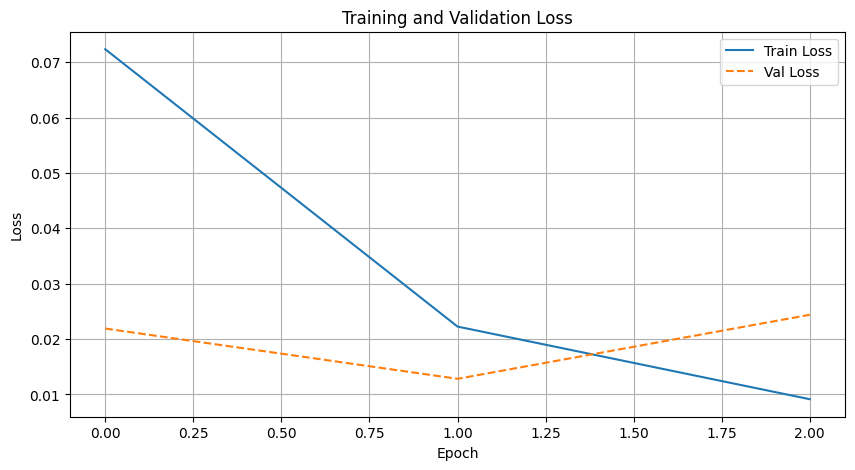

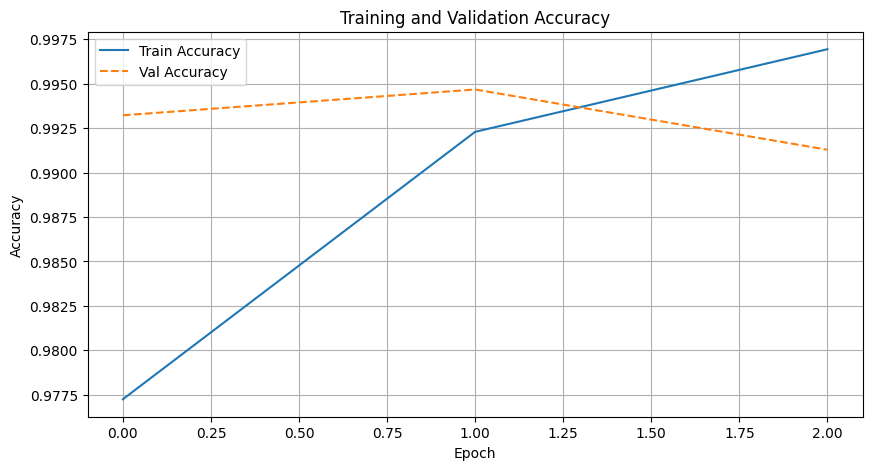

In [16]:
history_path = f'{model_name}_history.json'
plot_training_history(history_path)

## Re-test

In [17]:
model_path = f"{model_name}_model.pth"
test_model(model, model_name, model_path, test_loader)

Loading and testing model: naive_unlearning_EffNetB0_AFHQ


Evaluating model: naive_unlearning_EffNetB0_AFHQ_model.pth: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]

Predictions and labels saved to naive_unlearning_EffNetB0_AFHQ_predictions.json


## Show metrics

Metrics for naive_unlearning_EffNetB0_AFHQ:
  - Test Accuracy: 0.9980
  - Precision: 0.9980
  - Recall: 0.9980
  - F1 Score: 0.9980


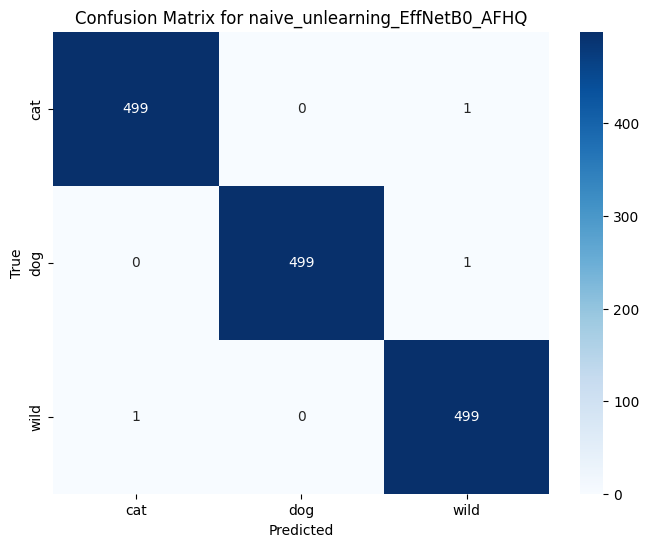

In [18]:
predictions_path = f'{model_name}_predictions.json'
#classes = ['cat', 'dog', 'wildlife']
show_metrics(predictions_path, classes, model_name)